<a href="https://colab.research.google.com/github/RennanRnz/RennanRnz/blob/main/MOD13TAR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [ ]:
import pandas as pd
import numpy as np
import patsy
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.tree import export_graphviz

In [ ]:
df = pd.read_csv('previsao_de_renda.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).


In [ ]:
# Selecionando as colunas relevantes.
df = df.iloc[:,3:]

In [ ]:
# Dividindo os dados em conjuntos de treinamento e teste.
df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)

# Definindo o modelo.
modelo = '''renda ~ sexo
                    + posse_de_veiculo
                    + posse_de_imovel
                    + qtd_filhos
                    + tipo_renda
                    + educacao
                    + estado_civil
                    + tipo_residencia
                    + idade
                    + tempo_emprego
                    + qt_pessoas_residencia
                    '''

# Criando as matrizes de design.
y_train, X_train = patsy.dmatrices(modelo, data=df_train)
y_test, X_test = patsy.dmatrices(modelo, data=df_test)

2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?

In [ ]:
# Def valores de alpha.
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

# Lista para armazenar os valores de R².
r2_values = []

In [ ]:
# Loop sobre os valores de alpha.
for alpha in alphas:
    # Modelo OLS.
    model = sm.OLS(y_train, X_train)

    # Ajustando o modelo com regularização Ridge.
    reg = model.fit_regularized(method='elastic_net', alpha=alpha, L1_wt=0)

    # Previsões da base de teste.
    y_pred = reg.predict(X_test)

    # Calculando o R² da base de testes.
    r2 = r2_score(y_test, y_pred)

    # Adicionando o R²  à lista.
    r2_values.append(r2)

In [ ]:
# Criando DataFrame dos resultados.
results = pd.DataFrame({'alpha': alphas, 'R²': r2_values})

# Ordenando o DataFrame pelos valores de R² em ordem decrescente.
results = results.sort_values(by='R²', ascending=False)

print(results)

   alpha        R²
0  0.000  0.262434
1  0.001  0.262262
2  0.005  0.261966
3  0.010  0.261568
4  0.050  0.256383
5  0.100  0.248634


 - Realizando análise:

In [ ]:
# Encontrando a linha com o maior valor de R²
best_row = results.loc[results['R²'].idxmax()]

# Imprimindo o melhor alpha e o correspondente R²
print(f'Entre os modelos de regressão com regularização ridge que testamos, aquele com alpha igual a {best_row["alpha"]}.')
print(f'O coeficiente de determinação mais alto alcaçado apresenta um R² de {best_row["R²"]}')

Entre os modelos de regressão com regularização ridge que testamos, aquele com alpha igual a 0.0.
O coeficiente de determinação mais alto alcaçado apresenta um R² de 0.262434034428185


3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?

In [ ]:
# Def os valores de alpha.
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

# Lista para armazenar os valores de R².
r2_values = []

In [ ]:
# Loop sobre os valores de alpha.
for alpha in alphas:
    # Modelo OLS.
    model = sm.OLS(y_train, X_train)

    # Ajustando o modelo com regularização Lasso.
    reg = model.fit_regularized(method='elastic_net', alpha=alpha, L1_wt=1)

    # Fazendo previsões na base de teste.
    y_pred = reg.predict(X_test)

    # Calculando o R² na base de teste.
    r2 = r2_score(y_test, y_pred)

    # Adicionando o R² à lista.
    r2_values.append(r2)

In [ ]:
# Criando um DataFrame com os resultados
results = pd.DataFrame({'alpha': alphas, 'R²': r2_values})

# Ordenando o DataFrame pelos valores de R² em ordem decrescente
results = results.sort_values(by='R²', ascending=False)

print(results)

   alpha        R²
0  0.000  0.261122
1  0.001  0.261122
2  0.005  0.261121
3  0.010  0.261120
5  0.100  0.261105
4  0.050  0.261083


 - Realizando análise:

In [ ]:
# Encontrando a linha com o maior valor de R².
best_row = results.loc[results['R²'].idxmax()]

# Visualizando o melhor alpha e o correspondente R².
print(f'Com base nos resultados, o melhor valor para alpha é {best_row["alpha"]}, que resultou em um R² de {best_row["R²"]}.\n')
print(f'Isso significa que o modelo com alpha = {best_row["alpha"]} é o que melhor se ajusta aos dados, de acordo com a métrica R².')

Com base nos resultados, o melhor valor para alpha é 0.0, que resultou em um R² de 0.261121948111378.

Isso significa que o modelo com alpha = 0.0 é o que melhor se ajusta aos dados, de acordo com a métrica R².


4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?


In [ ]:
# Tratando variáveis categóricas.
df_dummies = pd.get_dummies(data=df.dropna(), drop_first=True).astype(int)

# Separando as variáveis independentes e a variável destino.
X = df_dummies.drop(columns='renda')
y = df_dummies['renda']

# Dividindo o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Função para a seleção de recursos usando Stepwise
def stepwise_selection(X, y, initial_list=[], threshold_in=0.05, threshold_out=0.05, verbose=True):
    included = list(initial_list)

    while True:
        changed = False

        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=np.dtype('float64'))

        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]

        best_pval = new_pval.min()

        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True

            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))


        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()

        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True

            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))

        if not changed:
            break

    return included

In [ ]:
# Realizando a seleção de recursos no conjunto de teste.
selected_features = stepwise_selection(X_test, y_test)

# Selecionando as colunas do conjunto de treinamento de acordo com as características escolhidas.
X_train_selected = X_train[selected_features]

# Treinando um modelo OLS com as características escolhidas.
model = sm.OLS(y_train, sm.add_constant(X_train_selected)).fit()

# Fazendo previsões na base de teste com o modelo treinado.
y_pred = model.predict(sm.add_constant(X_test[selected_features]))

Add  tempo_emprego                  with p-value 1.15416e-120
Add  sexo_M                         with p-value 1.97372e-116
Add  educacao_Superior completo     with p-value 0.00030172
Add  idade                          with p-value 0.000294673
Add  posse_de_veiculo               with p-value 0.00268263
Add  tipo_renda_Empresário          with p-value 0.0127891
Add  qt_pessoas_residencia          with p-value 0.0167073
Add  tipo_residencia_Estúdio        with p-value 0.039098


In [ ]:
# Avaliando o R² da nossa base de testes.
r2 = r2_score(y_test, y_pred)

print(f'R²: {r2}')

R²: 0.29570088855946286


5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?


- Se baseando nos valores obtidos de ```R²``` o modelo que nos retornou o valor maior foi o modelo ```stepwise```, porem a diferença em relação aos modelos de regressão ```Ridge``` e ```Lasso``` é muito pequena, possivelmente o modelo de ```stepwise``` capturou alguma informação adicionar que os demais modelos não capturaram.

6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.


In [ ]:
# Tratando as variáveis categóricas.
df_dummies = pd.get_dummies(data=df.dropna(), drop_first=True).astype(int)

# Criando uma nova variável que representa a soma de posse_de_veiculo e posse_de_imovel.
df_dummies['posse_total'] = df_dummies['posse_de_veiculo'] + df_dummies['posse_de_imovel']

# Aplicando log na variável renda.
df_dummies['log_renda'] = np.log(df_dummies['renda'])

# Separando as variáveis independentes e a variável destino.
X = df_dummies.drop(columns=['renda', 'log_renda'])
y = df_dummies['log_renda']

# Dividindo o conjunto de dados em treinamento e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Treinando um modelo OLS com as características selecionadas.
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Fazendo previsões na base de teste com o modelo treinado.
y_pred = model.predict(sm.add_constant(X_test))

# Avaliando o R² na base de testes.
r2 = r2_score(y_test, y_pred)

print(f'O R² obtido após alterações e transformações foi de: {r2}')

O R² obtido após alterações e transformações foi de: 0.3628134917621014


7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

In [ ]:
# Separando as variáveis independentes e a variável de destino
X = df_dummies.drop(columns='renda')
y = df_dummies['renda']

# Dividindo o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Criando e treinando a árvore de regressão
tree_regressor = DecisionTreeRegressor(random_state=42, max_depth=5, min_samples_leaf=13)
tree_regressor.fit(X_train, y_train)

# Fazendo previsões na base de teste
y_pred = tree_regressor.predict(X_test)

# Avaliando o R² na base de testes
r2 = r2_score(y_test, y_pred)

print(f'R² com árvore de regressão: {r2}')

R² com árvore de regressão: 0.9924535625430829


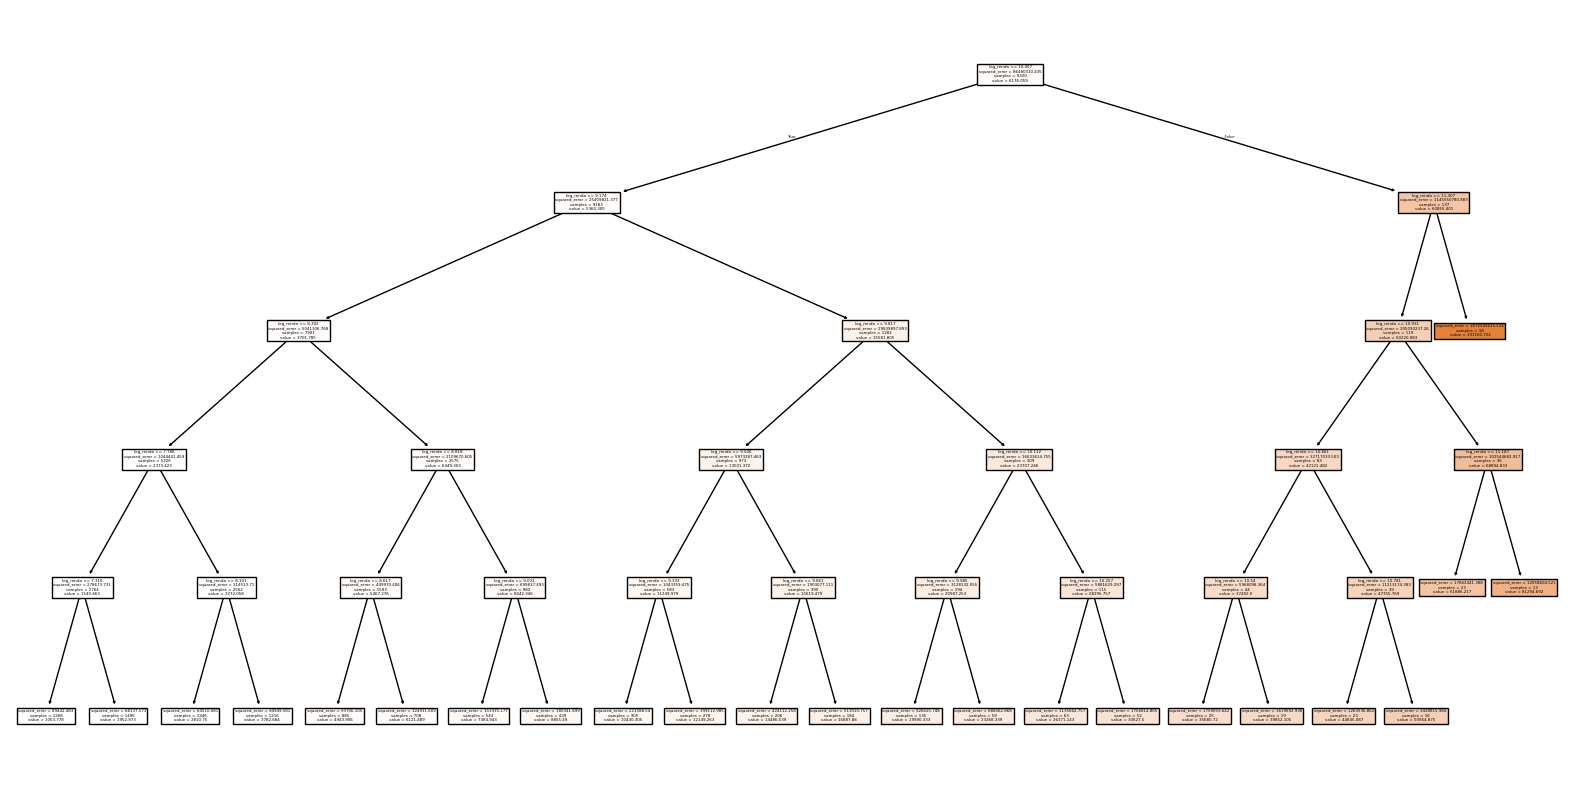

In [ ]:
# Visualização da árvore.
plt.figure(figsize=(20,10))
plot_tree(tree_regressor, filled=True, feature_names=X.columns, class_names=['renda'])
plt.show()

------